### Only supports Ethereum Mainnet for now. (But very easy to extend to other chains)

In [20]:
from web3 import Web3
from dotenv import load_dotenv
import os
import json
import requests
import json
from datetime import datetime, timedelta
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from matplotlib.gridspec import GridSpec

# Load environment variables from .env file
load_dotenv()

blacklisted_wallets = [
    "0xdead000000000000000042069420694206942069",
    "0x0000000000000000000000000000000000000000",
]

web3 = Web3(Web3.HTTPProvider(os.getenv("ALCHEMY_ETHEREUM_RPC_URL")))

with open("abis/ERC20.json", "r") as f:
    ERC20_ABI = json.load(f)

SHIB_INU = "0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE"

### General Methods

In [3]:
def is_contract_address(address: str) -> bool:
    """
    Check if an address is a contract address

    Args:
        address: Ethereum address to check

    Returns:
        bool: True if contract address, False if EOA (externally owned account)
    """
    # First verify it's a valid address
    if not web3.isAddress(address):
        return False

    # Get the code at the address
    code = web3.eth.get_code(web3.toChecksumAddress(address))

    # If there's code at the address, it's a contract
    # If no code (b'0x' or empty bytes), it's an EOA
    return code != b"" and code != b"0x"


def get_bitquery_access_token() -> str:
    url = "https://oauth2.bitquery.io/oauth2/token"

    payload = f'grant_type=client_credentials&client_id={os.getenv("BITQUERY_CLIENT_ID")}&client_secret={os.getenv("BITQUERY_CLIENT_SECRET")}&scope=api'

    headers = {"Content-Type": "application/x-www-form-urlencoded"}

    response = requests.request("POST", url, headers=headers, data=payload)
    resp = json.loads(response.text)

    return resp["access_token"]


def get_token_holders(token_address: str, limit: int = 10) -> dict:
    """
    Get top token holders for a given token address using BitQuery API

    Args:
        token_address: Ethereum token contract address
        limit: Number of top holders to return (default 10)

    Returns:
        dict: Response containing token holder data
    """

    access_token = get_bitquery_access_token()
    url = "https://streaming.bitquery.io/graphql"
    headers = {
        "Content-Type": "application/json",
        "Authorization": f"Bearer {access_token}",
    }

    payload = json.dumps(
        {
            "query": """
        {
      EVM(network: eth, dataset: archive) {
        TokenHolders(
          date: "%s"
          tokenSmartContract: "%s"
          limit: {count: %d}
          orderBy: {descendingByField: "Balance_Amount"}
        ) {
          Balance {
            Amount
          }
          Holder {
            Address
          }
        }
      }
    }
        """
            % (datetime.now().strftime("%Y-%m-%d"), token_address, limit)
        }
    )

    try:
        response = requests.post(url, headers=headers, data=payload)
        holders = response.json()["data"]["EVM"]["TokenHolders"]
        return [
            {
                "balance": float(h["Balance"]["Amount"]),
                "address": h["Holder"]["Address"],
            }
            for h in holders
        ]
    except Exception as e:
        print(f"An error occurred: {str(e)}")
        return None


def assert_token_address(token_address: str):
    assert web3.isAddress(token_address), "Invalid token address"


## Whale Monitoring

In [18]:
def get_recent_transfers(token_address: str, wallet_address: str, days: int = 7):
    """
    Get the transfers of a wallet for a given token in the last n days

    Args:
        token_address: The token contract address
        wallet_address: The wallet address to get transfers for
        days: The number of days to get transfers for

    Returns:
        list: A list of transfers
    """
    assert_token_address(token_address)
    assert_token_address(wallet_address)

    # Create contract instance
    token_contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)

    # Get current block
    current_block = web3.eth.block_number

    # Calculate block from n days ago (assuming 12.07 seconds per block)
    blocks_per_day = 24 * 60 * 60 // 12.07
    from_block = current_block - int(blocks_per_day * days)

    try:
        # Get transfers FROM the wallet
        outgoing_filter = token_contract.events.Transfer.createFilter(
            fromBlock=from_block,
            toBlock="latest",
            argument_filters={"from": wallet_address},
        )
        outgoing_events = outgoing_filter.get_all_entries()

        # Get transfers TO the wallet
        incoming_filter = token_contract.events.Transfer.createFilter(
            fromBlock=from_block,
            toBlock="latest",
            argument_filters={"to": wallet_address},
        )
        incoming_events = incoming_filter.get_all_entries()

        # Combine and format transfers
        all_transfers = []

        for event in outgoing_events + incoming_events:
            transfer = {
                "blockNumber": event["blockNumber"],
                "transactionHash": event["transactionHash"].hex(),
                "from": event["args"]["from"],
                "to": event["args"]["to"],
                "value": event["args"]["value"],
                "type": (
                    "out"
                    if event["args"]["from"].lower() == wallet_address.lower()
                    else "in"
                ),
            }
            all_transfers.append(transfer)

        # Sort by block number (most recent first)
        all_transfers.sort(key=lambda x: x["blockNumber"], reverse=True)

        return all_transfers

    except Exception as e:
        print(f"Error fetching transfers: {str(e)}")
        return []


def monitor_whale_wallets(token_address: str, days: int = 7):
    """
    Monitor whale wallets for a given token, analyzing their balances, transfers, and activity patterns
    
    Args:
        token_address (str): The token contract address to analyze
        days (int, optional): Number of days to look back for transfer history. Defaults to 7
        
    Returns:
        dict: A dictionary containing detailed whale monitoring data with the following structure:
            {
                'token_info': {
                    'address': str,         # The token's contract address
                    'symbol': str,          # The token's symbol (e.g., 'SHIB', 'UNI')
                    'total_supply': float,  # Total token supply adjusted for decimals
                    'whale_threshold': float # Minimum balance to be considered a whale (1% of supply)
                },
                
                'analysis_timeframe': str,  # Description of analysis period (e.g., "Last 7 days")
                
                'whales': [                 # List of whale wallet data
                    {
                        'address': str,     # Whale's wallet address
                        'current_balance': float,  # Current token balance
                        'percentage_of_supply': float,  # Percentage of total supply held
                        
                        'transfer_activity': {
                            'total_transfers': int,    # Total number of transfers
                            'outgoing_transfers': int, # Number of outgoing transfers
                            'incoming_transfers': int, # Number of incoming transfers
                            'total_outgoing_amount': float,  # Total tokens sent
                            'total_incoming_amount': float,  # Total tokens received
                            'net_flow': float,        # Net token flow (incoming - outgoing)
                        },
                        
                        'recent_transfers': [         # List of recent transfers
                            {
                                'block_number': int,  # Block number of transfer
                                'transaction_hash': str,  # Transaction hash
                                'type': str,         # 'in' or 'out'
                                'counterparty': str, # Address of sender/receiver
                                'amount': float,     # Transfer amount
                                'direction': str     # 'incoming' or 'outgoing'
                            },
                            ...
                        ]
                    },
                    ...
                ]
            }
            
            If there's an error:
            {
                'error': str,  # Error message
                'token_address': str  # The token address that was analyzed
            }
    
    Example:
        >>> data = monitor_whale_wallets("0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE")
        >>> print(f"Number of whales: {len(data['whales'])}")
        >>> print(f"Largest whale balance: {data['whales'][0]['current_balance']}")
        >>> print(f"Recent activity: {data['whales'][0]['transfer_activity']}")
    
    Notes:
        - Whale Definition:
          * Minimum 1% of total token supply
          * Must be an EOA (externally owned account), not a contract
          * Not in blacklisted addresses
        
        - Transfer Activity Analysis:
          * Tracks both incoming and outgoing transfers
          * Calculates net token flow
          * Identifies patterns of accumulation or distribution
        
        - Important Metrics:
          * percentage_of_supply: Individual whale's market control
          * net_flow: Whether whale is accumulating or distributing
          * transfer_activity: Overall trading behavior
        
        - Blacklisted addresses include:
          * Dead addresses (0xdead...)
          * Zero address (0x0000...)
          * Known burn addresses
    """
    assert_token_address(token_address)
    token_contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)

    # Get token metadata
    decimals = token_contract.functions.decimals().call()
    total_supply = token_contract.functions.totalSupply().call() / (10**decimals)
    token_symbol = token_contract.functions.symbol().call()

    # Define whale threshold (>1% of supply)
    MIN_WHALE_HOLDINGS = total_supply * 0.01

    # Get all token holders
    holders = get_token_holders(token_address, 25)

    # Filter holders and get their data
    whales_data = {
        "token_info": {
            "address": token_address,
            "symbol": token_symbol,
            "total_supply": total_supply,
            "whale_threshold": MIN_WHALE_HOLDINGS,
        },
        "analysis_timeframe": f"Last {days} days",
        "whales": [],
    }

    # Filter and process whale data
    for holder in holders:
        if (
            holder["balance"] > MIN_WHALE_HOLDINGS
            and not is_contract_address(holder["address"])
            and holder["address"] not in blacklisted_wallets
        ):

            # Get recent transfers for this whale
            recent_transfers = get_recent_transfers(
                token_address, holder["address"], days
            )

            # Calculate transfer statistics
            outgoing_transfers = [t for t in recent_transfers if t["type"] == "out"]
            incoming_transfers = [t for t in recent_transfers if t["type"] == "in"]

            total_outgoing = sum(t["value"] for t in outgoing_transfers) / (
                10**decimals
            )
            total_incoming = sum(t["value"] for t in incoming_transfers) / (
                10**decimals
            )

            whale_data = {
                "address": holder["address"],
                "current_balance": holder["balance"],
                "percentage_of_supply": (holder["balance"] / total_supply) * 100,
                "transfer_activity": {
                    "total_transfers": len(recent_transfers),
                    "outgoing_transfers": len(outgoing_transfers),
                    "incoming_transfers": len(incoming_transfers),
                    "total_outgoing_amount": total_outgoing,
                    "total_incoming_amount": total_incoming,
                    "net_flow": total_incoming - total_outgoing,
                },
                "recent_transfers": [
                    {
                        "block_number": transfer["blockNumber"],
                        "transaction_hash": transfer["transactionHash"],
                        "type": transfer["type"],
                        "counterparty": (
                            transfer["to"]
                            if transfer["type"] == "out"
                            else transfer["from"]
                        ),
                        "amount": transfer["value"] / (10**decimals),
                        "direction": (
                            "outgoing" if transfer["type"] == "out" else "incoming"
                        ),
                    }
                    for transfer in recent_transfers
                ],
            }

            whales_data["whales"].append(whale_data)

    # Sort whales by balance
    whales_data["whales"].sort(key=lambda x: x["current_balance"], reverse=True)

    return whales_data


## Token Distribution Analysis

In [16]:
def calculate_gini_coefficient(holders: list) -> float:
    """
    Calculate the Gini coefficient for token distribution
    A measure of inequality where 0 = perfect equality and 1 = perfect inequality
    
    Args:
        holders: List of dictionaries containing holder balances
        
    Returns:
        float: Gini coefficient between 0 and 1
    """
    if not holders:
        return 0
    
    # Sort balances in ascending order
    balances = sorted([holder['balance'] for holder in holders])
    n = len(balances)
    
    # Calculate cumulative sum
    cumsum = [sum(balances[0:i+1]) for i in range(n)]
    total = cumsum[-1]
    
    # Calculate Gini coefficient using the formula
    gini = (n + 1 - 2 * sum([(n - i) * balance / total for i, balance in enumerate(balances)])) / n
    
    return max(0, min(1, gini))  # Ensure result is between 0 and 1


def calculate_nakamoto_coefficient(holders: list, total_supply: float) -> int:
    """
    Calculate the Nakamoto Coefficient - the minimum number of entities required to reach 51% of token supply
    
    Args:
        holders: List of dictionaries containing holder balances
        total_supply: Total token supply
        
    Returns:
        int: Nakamoto coefficient (number of holders needed for 51% control)
    """
    if not holders:
        return 0
        
    cumulative_percentage = 0
    for i, holder in enumerate(sorted(holders, key=lambda x: x['balance'], reverse=True)):
        cumulative_percentage += (holder['balance'] / total_supply) * 100
        if cumulative_percentage >= 51:
            return i + 1
    return len(holders)

def calculate_theil_index(holders: list) -> float:
    """
    Calculate the Theil Index - a measure of economic inequality
    The index ranges from 0 (perfect equality) to ln(n) (perfect inequality)
    
    Args:
        holders: List of dictionaries containing holder balances
        
    Returns:
        float: Theil index value
    """
    if not holders:
        return 0
        
    balances = [holder['balance'] for holder in holders]
    n = len(balances)
    
    if n == 1:
        return 0
        
    # Calculate mean balance
    mean_balance = sum(balances) / n
    
    # Calculate Theil index
    theil = 0
    for balance in balances:
        if balance > 0:  # Avoid log(0)
            ratio = balance / mean_balance
            theil += (ratio * math.log(ratio)) / n
            
    return max(0, theil)  # Ensure non-negative


# potential method to use later. Not using it now since its too slow
def get_new_holders_24h(token_address: str, max_transfers: int = 100) -> int:
    """
    Get the number of new token holders in the last 24 hours using web3.py events
    
    Args:
        token_address (str): The token contract address
        max_transfers (int, optional): Maximum number of recent transfers to analyze. Defaults to 100.
        
    Returns:
        int: Number of new holders in last 24 hours
    """
    assert_token_address(token_address)
    
    # Create contract instance
    token_contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
    
    # Calculate block from 24 hours ago (assuming 12 seconds per block)
    current_block = web3.eth.block_number
    blocks_per_day = 24 * 60 * 60 // 12  # Approximately 7200 blocks per day
    from_block = current_block - blocks_per_day
    
    try:
        # Create filter for Transfer events
        transfer_filter = token_contract.events.Transfer().createFilter(
            fromBlock=from_block,
            toBlock='latest'
        )
        
        # Get all transfer events
        transfers = transfer_filter.get_all_entries()
        
        # Track potential new holders and checked addresses
        potential_new_holders = set()
        checked_addresses = set()  # Track addresses we've already checked
        
        # Get last N transfers (most recent first)
        for transfer in sorted(transfers, key=lambda x: x['blockNumber'], reverse=True)[:max_transfers]:
            receiver = transfer['args']['to']
            
            # Skip if we've already checked this address
            if receiver.lower() in checked_addresses:
                continue
                
            # Skip if receiver is a contract 
            if (is_contract_address(receiver)):
                checked_addresses.add(receiver.lower())  # Mark as checked
                continue
                
            # Check if this address had any balance before this transfer
            try:
                # Get block number just before this transfer
                prev_block = transfer['blockNumber'] - 1
                
                # Check balance at previous block
                prev_balance = token_contract.functions.balanceOf(receiver).call(
                    block_identifier=prev_block
                )
                
                # Mark address as checked
                checked_addresses.add(receiver.lower())
                
                # If balance was 0 before this transfer, it's a new holder
                if prev_balance == 0:
                    potential_new_holders.add(receiver.lower())
                    
            except Exception as e:
                print(f"Error checking previous balance: {str(e)}")
                continue
        
        return len(potential_new_holders)
        
    except Exception as e:
        print(f"Error fetching new holders: {str(e)}")
        return 0

In [17]:
def analyze_token_distribution(token_address: str) -> dict:
    """
    Analyze the token distribution metrics including Gini coefficient and holder concentration
    
    Args:
        token_address (str): The token contract address to analyze
        
    Returns:
        dict: A dictionary containing detailed token distribution analysis with the following structure:
            {
                'token_info': {
                    'address': str,  # The token's contract address
                    'symbol': str,   # The token's symbol (e.g., 'SHIB', 'UNI')
                    'total_supply': float  # Total token supply adjusted for decimals
                },
                'distribution_metrics': {
                    'gini_coefficient': float,  # Value between 0-1, where:
                                              # 0 = perfect equality
                                              # 1 = perfect inequality
                                              # Higher values indicate more concentrated ownership
                    
                    'top_holder_concentration': {
                        'top_1_percentage': float,  # Percentage of supply held by largest holder
                        'top_5_percentage': float,  # Percentage of supply held by top 5 holders
                        'top_10_percentage': float  # Percentage of supply held by top 10 holders
                    },

                    'concentration_metrics': {
                        'nakamoto_interpretation': str,  # Interpretation of Nakamoto coefficient
                        'theil_interpretation': str      # Interpretation of Theil index
                    },
                    
                    'holder_statistics': {
                        'total_holders_analyzed': int,  # Number of holders analyzed (max 100)
                        'non_contract_holders': int,    # Number of holders that are EOAs (not contracts)
                    }
                },
                'timestamp': str  # ISO format timestamp of when analysis was performed
            }
            
            If there's an error fetching data:
            {
                'error': str,  # Error message
                'token_address': str  # The token address that was analyzed
            }
            
    Example:
        >>> data = analyze_token_distribution("0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE")
        >>> print(data['distribution_metrics']['gini_coefficient'])
        0.8411298486981609
        >>> print(data['distribution_metrics']['top_holder_concentration']['top_1_percentage'])
        41.04368089149804
    
    Notes:
        - Gini coefficient interpretation:
          * 0.0-0.3: Low concentration
          * 0.3-0.6: Moderate concentration
          * 0.6-0.8: High concentration
          * 0.8-1.0: Very high concentration
        
        - Top holder concentration interpretation:
          * >50% by top 1: Potential centralization risk
          * >70% by top 10: High centralization
          
        - Non-contract holders ratio can indicate institutional vs retail ownership
    """
    assert_token_address(token_address)
    
    # Create contract instance
    token_contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
    
    # Get token metadata
    decimals = token_contract.functions.decimals().call()
    total_supply = token_contract.functions.totalSupply().call() / (10**decimals)
    token_symbol = token_contract.functions.symbol().call()
    
    # Get all holders (limited to top 100 for practical purposes)
    holders = get_token_holders(token_address, 100)
    if not holders:
        return {
            'error': 'Failed to fetch holder data',
            'token_address': token_address
        }
    
    # Calculate Gini coefficient
    gini = calculate_gini_coefficient(holders)
    
    # Calculate top holder concentrations
    top_10_holders = holders[:10] if len(holders) >= 10 else holders
    top_10_balance = sum(holder['balance'] for holder in top_10_holders)
    top_10_percentage = (top_10_balance / total_supply) * 100
    
    # Calculate other concentration metrics
    top_1_percentage = (holders[0]['balance'] / total_supply * 100) if holders else 0
    top_5_percentage = (sum(h['balance'] for h in holders[:5]) / total_supply * 100) if len(holders) >= 5 else 0
    
    # Count non-contract holders
    non_contract_holders = sum(1 for holder in holders if not is_contract_address(holder['address']))

    # Calculate additional concentration metrics
    nakamoto_coef = calculate_nakamoto_coefficient(holders, total_supply)
    theil_index = calculate_theil_index(holders)
    
    return {
        'token_info': {
            'address': token_address,
            'symbol': token_symbol,
            'total_supply': total_supply
        },
        'distribution_metrics': {
            'gini_coefficient': gini,
            'top_holder_concentration': {
                'top_1_percentage': top_1_percentage,
                'top_5_percentage': top_5_percentage,
                'top_10_percentage': top_10_percentage
            },
            'concentration_metrics': {
                'nakamoto_interpretation': 'High centralization' if nakamoto_coef < 4 else 
                                        'Moderate centralization' if nakamoto_coef < 10 else 
                                        'Decentralized',
                'theil_interpretation': 'High inequality' if theil_index > 1 else
                                      'Moderate inequality' if theil_index > 0.5 else
                                      'Low inequality'
            },
            'holder_statistics': {
                'total_holders_analyzed': len(holders),
                'non_contract_holders': non_contract_holders
            }
        },
        'timestamp': datetime.now().isoformat()
    }

In [28]:
analyze_token_distribution(SHIB_INU)

{'token_info': {'address': '0x95aD61b0a150d79219dCF64E1E6Cc01f0B64C4cE',
  'symbol': 'SHIB',
  'total_supply': 999982339482145.2},
 'distribution_metrics': {'gini_coefficient': 0.8411298486981609,
  'top_holder_concentration': {'top_1_percentage': 41.04368089149804,
   'top_5_percentage': 57.20194959238959,
   'top_10_percentage': 61.413550410113594},
  'concentration_metrics': {'nakamoto_interpretation': 'Moderate centralization',
   'theil_interpretation': 'High inequality'},
  'holder_statistics': {'total_holders_analyzed': 100,
   'non_contract_holders': 91}},
 'timestamp': '2025-02-16T18:15:28.114920'}

## Volume Pattern Analysis

In [5]:
def get_ohlcv_data(token_address: str) -> dict:
    """
    Get OHLCV (Open, High, Low, Close, Volume) data for a token from geckoterminal
    
    Args:
        token_address (str): The token contract address

    Returns:
        list: A list of OHLCV data points in the format:
        [timestamp, open, high, low, close, volume]
"""

    base_url = "https://api.geckoterminal.com/api/v2"

    # get the top pools for the token
    pools_url = f"{base_url}/networks/eth/tokens/{token_address}/pools"
    response = requests.get(pools_url)
    
    top_pool = response.json()['data'][0]['attributes']['address']

    # Get OHLCV data
    # For 1 month of data, using 1h interval as it's the best balance for AI analysis
    ohlcv_url = f"{base_url}/networks/eth/pools/{top_pool}/ohlcv/hour"
    
    params = {
        "currency": "usd"  ,   # Get prices in USD
        "limit": 1000
    }
    
    response = requests.get(ohlcv_url, params=params)

    return response.json()['data']['attributes']['ohlcv_list']


In [6]:
data = get_ohlcv_data(SHIB_INU)

In [7]:
def calculate_average_daily_volume(ohlcv_data: list) -> float:
    """
    Calculate the average daily trading volume from hourly OHLCV data
    
    Args:
        ohlcv_data (list): List of hourly OHLCV data points where each point is
                          [timestamp, open, high, low, close, volume]
    
    Returns:
        float: Average daily trading volume (sum of 24 hourly volumes per day, 
               averaged across all days)
    """
    # Create a dictionary to store daily volumes
    daily_volumes = {}
    
    for datapoint in ohlcv_data:
        timestamp = datapoint[0]
        volume = datapoint[5]
        
        # Convert timestamp to date string (YYYY-MM-DD)
        date = datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d')
        
        # Add volume to daily total
        if date in daily_volumes:
            daily_volumes[date] += volume
        else:
            daily_volumes[date] = volume
    
    # Calculate average across all days
    total_volume = sum(daily_volumes.values())
    num_days = len(daily_volumes)
    
    return total_volume / num_days if num_days > 0 else 0

def analyze_volume_trends(ohlcv_data: list, ma_periods: tuple = (24, 72)) -> dict:
    """
    Analyze trading volume trends from OHLCV data
    
    Args:
        ohlcv_data (list): List of hourly OHLCV data points where each point is
                          [timestamp, open, high, low, close, volume]
        ma_periods (tuple): Periods for short and long moving averages in hours
                          (default: 24h and 72h)
    
    Returns:
        dict: Volume trend analysis with the following metrics:
            - recent_trend: Direction of volume trend ('increasing', 'decreasing', or 'stable')
            - volume_volatility: Coefficient of variation of volumes
            - moving_averages: Short and long-term moving averages
            - peak_volume: Highest volume in the period
            - peak_volume_time: Timestamp of highest volume
            - trend_strength: Strength of trend from 0-1 based on MA crossovers
            - volume_distribution: Distribution of volume across time periods
    """
    if not ohlcv_data:
        return None
        
    # Extract volumes and timestamps
    volumes = [point[5] for point in ohlcv_data]
    timestamps = [point[0] for point in ohlcv_data]
    
    # Calculate moving averages
    short_ma = []
    long_ma = []
    short_period, long_period = ma_periods
    
    for i in range(len(volumes)):
        if i >= short_period:
            short_ma.append(sum(volumes[i-short_period:i]) / short_period)
        if i >= long_period:
            long_ma.append(sum(volumes[i-long_period:i]) / long_period)
    
    # Calculate volume volatility (coefficient of variation)
    mean_volume = sum(volumes) / len(volumes)
    std_dev = (sum((v - mean_volume) ** 2 for v in volumes) / len(volumes)) ** 0.5
    volatility = std_dev / mean_volume if mean_volume > 0 else 0
    
    # Find peak volume
    peak_volume = max(volumes)
    peak_index = volumes.index(peak_volume)
    peak_timestamp = timestamps[peak_index]
    
    # Determine trend direction using recent moving averages
    if len(short_ma) > 2:
        recent_short_ma = short_ma[-3:]
        if recent_short_ma[-1] > recent_short_ma[0] * 1.05:  # 5% increase
            trend = 'increasing'
        elif recent_short_ma[-1] < recent_short_ma[0] * 0.95:  # 5% decrease
            trend = 'decreasing'
        else:
            trend = 'stable'
    else:
        trend = 'insufficient data'
    
    # Calculate trend strength based on MA crossovers
    trend_strength = 0
    if len(short_ma) > 0 and len(long_ma) > 0:
        # Compare last values of MAs
        if short_ma[-1] > long_ma[-1]:
            trend_strength = min((short_ma[-1] / long_ma[-1] - 1), 1)
        else:
            trend_strength = max((short_ma[-1] / long_ma[-1] - 1), -1)
    
    # Analyze volume distribution
    quartiles = {
        'q1': sorted(volumes)[len(volumes)//4],
        'median': sorted(volumes)[len(volumes)//2],
        'q3': sorted(volumes)[3*len(volumes)//4]
    }
    
    return {
        'recent_trend': trend,
        'volume_volatility': volatility,
        'moving_averages': {
            f'{short_period}h': short_ma[-1] if short_ma else None,
            f'{long_period}h': long_ma[-1] if long_ma else None
        },
        'peak_volume': {
            'amount': peak_volume,
            'timestamp': datetime.fromtimestamp(peak_timestamp).strftime('%Y-%m-%d %H:%M:%S')
        },
        'trend_strength': trend_strength,
        'volume_distribution': quartiles,
        'analysis_period': {
            'start': datetime.fromtimestamp(timestamps[-1]).strftime('%Y-%m-%d %H:%M:%S'),
            'end': datetime.fromtimestamp(timestamps[0]).strftime('%Y-%m-%d %H:%M:%S')
        }
    }


def detect_wash_trading(ohlcv_data: list, threshold_multiplier: float = 2.0) -> dict:
    """
    Detect potential wash trading patterns in OHLCV data
    
    Args:
        ohlcv_data (list): List of hourly OHLCV data points where each point is
                          [timestamp, open, high, low, close, volume]
        threshold_multiplier (float): Multiplier for standard deviation to detect anomalies
                                    (default: 2.0)
    
    Returns:
        dict: Wash trading analysis with the following metrics:
            {
                'summary': {
                    'wash_trading_risk': str,      # 'High', 'Medium', 'Low'
                    'confidence_score': float,     # 0-1 score of confidence in detection
                    'suspicious_periods': int      # Number of suspicious periods detected
                },
                'patterns': {
                    'volume_price_divergence': [   # Periods where volume and price patterns diverge
                        {
                            'timestamp': str,
                            'volume': float,
                            'price_change': float,
                            'divergence_score': float
                        },
                        ...
                    ],
                    'volume_anomalies': [         # Unusual volume patterns
                        {
                            'timestamp': str,
                            'volume': float,
                            'expected_volume': float,
                            'deviation': float
                        },
                        ...
                    ]
                },
                'metrics': {
                    'price_volume_correlation': float,  # Correlation between price and volume
                    'volume_consistency_score': float,  # Measure of volume pattern consistency
                    'price_impact_score': float        # Measure of volume's impact on price
                },
                'analysis_period': {
                    'start': str,
                    'end': str
                }
            }
    """
    if not ohlcv_data:
        return None
        
    # Extract data
    volumes = [point[5] for point in ohlcv_data]
    timestamps = [point[0] for point in ohlcv_data]
    prices = [point[4] for point in ohlcv_data]  # Using close prices
    
    # Calculate baseline metrics
    mean_volume = sum(volumes) / len(volumes)
    std_dev_volume = (sum((v - mean_volume) ** 2 for v in volumes) / len(volumes)) ** 0.5
    
    # Calculate price changes
    price_changes = [((prices[i] - prices[i-1]) / prices[i-1]) * 100 
                    for i in range(1, len(prices))]
    price_changes.insert(0, 0)  # Add 0 for first point
    
    # Detect volume anomalies
    volume_anomalies = []
    for i, volume in enumerate(volumes):
        deviation = (volume - mean_volume) / std_dev_volume if std_dev_volume > 0 else 0
        if abs(deviation) > threshold_multiplier:
            volume_anomalies.append({
                'timestamp': datetime.fromtimestamp(timestamps[i]).strftime('%Y-%m-%d %H:%M:%S'),
                'volume': volume,
                'expected_volume': mean_volume,
                'deviation': deviation
            })
    
    # Detect price-volume divergence
    divergence_patterns = []
    for i in range(len(volumes)):
        if i > 0:
            volume_change = (volumes[i] - volumes[i-1]) / volumes[i-1] if volumes[i-1] > 0 else 0
            price_change = price_changes[i]
            
            # Check for divergence (high volume with little price change or vice versa)
            if (abs(volume_change) > 0.5 and abs(price_change) < 0.1) or \
               (abs(volume_change) < 0.1 and abs(price_change) > 0.5):
                divergence_score = abs(volume_change - price_change)
                divergence_patterns.append({
                    'timestamp': datetime.fromtimestamp(timestamps[i]).strftime('%Y-%m-%d %H:%M:%S'),
                    'volume': volumes[i],
                    'price_change': price_change,
                    'divergence_score': divergence_score
                })
    
    # Calculate price-volume correlation
    def calculate_correlation(x, y):
        if len(x) != len(y):
            return 0
        n = len(x)
        mean_x = sum(x) / n
        mean_y = sum(y) / n
        covariance = sum((x[i] - mean_x) * (y[i] - mean_y) for i in range(n))
        std_x = (sum((val - mean_x) ** 2 for val in x)) ** 0.5
        std_y = (sum((val - mean_y) ** 2 for val in y)) ** 0.5
        if std_x == 0 or std_y == 0:
            return 0
        return covariance / (std_x * std_y)
    
    price_volume_correlation = calculate_correlation(volumes, [abs(p) for p in price_changes])
    
    # Calculate volume consistency score
    volume_changes = [abs((volumes[i] - volumes[i-1]) / volumes[i-1]) 
                     if volumes[i-1] > 0 else 0 
                     for i in range(1, len(volumes))]
    volume_consistency = 1 - (sum(volume_changes) / len(volume_changes))
    
    # Calculate wash trading risk score
    risk_factors = [
        len(volume_anomalies) / len(volumes),  # Proportion of anomalous volumes
        len(divergence_patterns) / len(volumes),  # Proportion of divergent patterns
        1 - abs(price_volume_correlation),  # Low correlation indicates potential wash trading
        1 - volume_consistency  # High volatility indicates potential wash trading
    ]
    risk_score = sum(risk_factors) / len(risk_factors)
    
    # Determine risk level
    if risk_score > 0.7:
        risk_level = 'High'
    elif risk_score > 0.4:
        risk_level = 'Medium'
    else:
        risk_level = 'Low'
    
    return {
        'summary': {
            'wash_trading_risk': risk_level,
            'confidence_score': 1 - (risk_score / 2),  # Convert risk score to confidence
            'suspicious_periods': len(volume_anomalies) + len(divergence_patterns)
        },
        'patterns': {
            'volume_price_divergence': sorted(divergence_patterns, 
                                            key=lambda x: x['divergence_score'], 
                                            reverse=True),
            'volume_anomalies': sorted(volume_anomalies, 
                                     key=lambda x: abs(x['deviation']), 
                                     reverse=True)
        },
        'metrics': {
            'price_volume_correlation': price_volume_correlation,
            'volume_consistency_score': volume_consistency,
            'price_impact_score': 1 - abs(price_volume_correlation)
        },
        'analysis_period': {
            'start': datetime.fromtimestamp(timestamps[-1]).strftime('%Y-%m-%d %H:%M:%S'),
            'end': datetime.fromtimestamp(timestamps[0]).strftime('%Y-%m-%d %H:%M:%S')
        }
    }

def analyze_volume_seasonality(ohlcv_data: list) -> dict:
    """
    Analyze trading volume seasonality and liquidity patterns
    
    Args:
        ohlcv_data (list): List of hourly OHLCV data points where each point is
                          [timestamp, open, high, low, close, volume]
    
    Returns:
        dict: Volume seasonality analysis with the following metrics:
            {
                'hourly_patterns': {
                    'peak_trading_hours': list,    # Hours with highest average volume
                    'low_volume_hours': list,      # Hours with lowest average volume
                    'hour_volatility': dict        # Volume volatility by hour
                },
                'liquidity_metrics': {
                    'average_hourly_volume': float,
                    'volume_stability': float,     # Measure of volume consistency
                    'liquidity_score': float      # Overall liquidity rating
                },
                'volume_concentration': {
                    'top_5_hours_volume': float,  # % of volume in top 5 hours
                    'gini_coefficient': float     # Measure of volume distribution
                },
                'slippage_estimation': {
                    'low_volume_slippage': float,  # Estimated slippage in low volume
                    'high_volume_slippage': float  # Estimated slippage in high volume
                }
            }
    """
    if not ohlcv_data:
        return None
        
    # Group volumes by hour
    hourly_volumes = {}
    for point in ohlcv_data:
        timestamp = point[0]
        volume = point[5]
        hour = datetime.fromtimestamp(timestamp).hour
        
        if hour not in hourly_volumes:
            hourly_volumes[hour] = []
        hourly_volumes[hour].append(volume)
    
    # Calculate hourly statistics
    hourly_stats = {}
    for hour, volumes in hourly_volumes.items():
        mean_volume = sum(volumes) / len(volumes)
        std_dev = (sum((v - mean_volume) ** 2 for v in volumes) / len(volumes)) ** 0.5
        
        hourly_stats[hour] = {
            'mean_volume': mean_volume,
            'std_dev': std_dev,
            'volatility': std_dev / mean_volume if mean_volume > 0 else 0,
            'sample_count': len(volumes)
        }
    
    # Identify peak and low volume hours
    sorted_hours = sorted(hourly_stats.items(), 
                         key=lambda x: x[1]['mean_volume'], 
                         reverse=True)
    
    peak_hours = [hour for hour, _ in sorted_hours[:5]]
    low_hours = [hour for hour, _ in sorted_hours[-5:]]
    
    # Calculate volume concentration
    total_volume = sum(stats['mean_volume'] for stats in hourly_stats.values())
    top_5_volume = sum(hourly_stats[hour]['mean_volume'] for hour in peak_hours)
    volume_concentration = (top_5_volume / total_volume) if total_volume > 0 else 0
    
    # Calculate liquidity metrics
    avg_hourly_volume = total_volume / 24
    volume_stability = 1 - (sum(stats['volatility'] for stats in hourly_stats.values()) / 24)
    
    # Estimate slippage based on volume patterns
    # Using a simple model where slippage is inversely proportional to volume
    base_slippage = 0.001  # 0.1% base slippage
    low_vol_slippage = base_slippage * (avg_hourly_volume / min(stats['mean_volume'] 
                                       for stats in hourly_stats.values()))
    high_vol_slippage = base_slippage * (avg_hourly_volume / max(stats['mean_volume'] 
                                        for stats in hourly_stats.values()))
    
    # Calculate liquidity score (0-1)
    liquidity_factors = [
        volume_stability,
        1 - volume_concentration,  # Lower concentration is better
        min(1, avg_hourly_volume / 10000)  # Normalize volume
    ]
    liquidity_score = sum(liquidity_factors) / len(liquidity_factors)
    
    return {
        'hourly_patterns': {
            'peak_trading_hours': [f"{hour:02d}:00" for hour in peak_hours],
            'low_volume_hours': [f"{hour:02d}:00" for hour in low_hours],
            'hour_volatility': {f"{hour:02d}:00": stats['volatility'] 
                              for hour, stats in hourly_stats.items()}
        },
        'liquidity_metrics': {
            'average_hourly_volume': avg_hourly_volume,
            'volume_stability': volume_stability,
            'liquidity_score': liquidity_score
        },
        'volume_concentration': {
            'top_5_hours_volume_percentage': volume_concentration * 100,
            'hourly_distribution': {f"{hour:02d}:00": stats['mean_volume'] / total_volume 
                                  for hour, stats in hourly_stats.items()}
        },
        'slippage_estimation': {
            'low_volume_slippage': low_vol_slippage,
            'high_volume_slippage': high_vol_slippage,
            'slippage_volatility': low_vol_slippage / high_vol_slippage
        },
        'trading_recommendations': {
            'best_hours_to_trade': [f"{hour:02d}:00" for hour in peak_hours[:3]],
            'hours_to_avoid': [f"{hour:02d}:00" for hour in low_hours[:3]],
            'liquidity_warning': "Low" if liquidity_score < 0.3 else 
                               "Medium" if liquidity_score < 0.7 else "High"
        }
    }

In [8]:
def analyze_token_volume_comprehensive(token_address: str, ohlcv_data: list) -> dict:
    """
    Perform comprehensive volume analysis combining all volume-related metrics
    
    Args:
        token_address (str): The token contract address to analyze
        ohlcv_data (list): List of OHLCV data points
        
    Returns:
        dict: Comprehensive volume analysis with structured data suitable for AI processing:
            {
                'token_info': {
                    'address': str,
                    'symbol': str,
                    'analysis_period': {
                        'start': str,
                        'end': str,
                        'duration_days': int
                    }
                },
                'volume_metrics': {
                    'basic_metrics': {
                        'average_daily_volume': float,
                        'average_hourly_volume': float,
                        'peak_volume': float,
                        'min_volume': float,
                        'volume_std_dev': float
                    },
                    'trend_analysis': {
                        'current_trend': str,
                        'trend_strength': float,
                        'moving_averages': dict,
                        'volatility': float
                    }
                },
                'trading_patterns': {
                    'seasonality': {
                        'peak_hours': list,
                        'low_volume_hours': list,
                        'hourly_distribution': dict
                    },
                    'wash_trading_indicators': {
                        'risk_level': str,
                        'confidence_score': float,
                        'suspicious_patterns': list
                    }
                },
                'liquidity_analysis': {
                    'liquidity_score': float,
                    'volume_stability': float,
                    'slippage_estimates': dict,
                    'concentration_metrics': dict
                },
                'anomaly_detection': {
                    'volume_anomalies': list,
                    'price_volume_divergences': list,
                    'unusual_patterns': list
                },
                'ai_insights': {
                    'key_findings': list,
                    'risk_factors': list,
                    'trading_recommendations': list,
                    'market_health_indicators': dict
                }
            }
    """
    try:
        # Get token contract for metadata
        token_contract = web3.eth.contract(address=token_address, abi=ERC20_ABI)
        token_symbol = token_contract.functions.symbol().call()
        
        # Perform all analyses
        volume_trends = analyze_volume_trends(ohlcv_data)
        wash_trading = detect_wash_trading(ohlcv_data)
        seasonality = analyze_volume_seasonality(ohlcv_data)
        avg_daily_volume = calculate_average_daily_volume(ohlcv_data)
        
        # Extract timestamps for period analysis
        timestamps = [point[0] for point in ohlcv_data]
        start_time = datetime.fromtimestamp(min(timestamps))
        end_time = datetime.fromtimestamp(max(timestamps))
        duration_days = (end_time - start_time).days
        
        # Extract volumes for basic metrics
        volumes = [point[5] for point in ohlcv_data]
        
        # Generate key findings and recommendations
        key_findings = []
        risk_factors = []
        recommendations = []
        
        # Analyze volume trends
        if volume_trends['recent_trend'] == 'increasing':
            key_findings.append('Volume showing upward trend')
        elif volume_trends['recent_trend'] == 'decreasing':
            key_findings.append('Volume showing downward trend')
            risk_factors.append('Declining volume may indicate reduced market interest')
            
        # Analyze wash trading risk
        if wash_trading['summary']['wash_trading_risk'] == 'High':
            risk_factors.append('High risk of wash trading detected')
            recommendations.append('Exercise caution due to potential market manipulation')
            
        # Analyze liquidity
        if seasonality['liquidity_metrics']['liquidity_score'] < 0.5:
            risk_factors.append('Low liquidity conditions')
            recommendations.append('Consider trading during peak volume hours')
            
        # Structured comprehensive analysis
        return {
            'token_info': {
                'address': token_address,
                'symbol': token_symbol,
                'analysis_period': {
                    'start': start_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'end': end_time.strftime('%Y-%m-%d %H:%M:%S'),
                    'duration_days': duration_days
                }
            },
            'volume_metrics': {
                'basic_metrics': {
                    'average_daily_volume': avg_daily_volume,
                    'average_hourly_volume': sum(volumes) / len(volumes),
                    'peak_volume': max(volumes),
                    'min_volume': min(volumes),
                    'volume_std_dev': (sum((v - avg_daily_volume/24) ** 2 for v in volumes) 
                                     / len(volumes)) ** 0.5
                },
                'trend_analysis': {
                    'current_trend': volume_trends['recent_trend'],
                    'trend_strength': volume_trends['trend_strength'],
                    'moving_averages': volume_trends['moving_averages'],
                    'volatility': volume_trends['volume_volatility']
                }
            },
            'trading_patterns': {
                'seasonality': {
                    'peak_hours': seasonality['hourly_patterns']['peak_trading_hours'],
                    'low_volume_hours': seasonality['hourly_patterns']['low_volume_hours'],
                    'hourly_distribution': seasonality['volume_concentration']['hourly_distribution']
                },
                'wash_trading_indicators': {
                    'risk_level': wash_trading['summary']['wash_trading_risk'],
                    'confidence_score': wash_trading['summary']['confidence_score'],
                    'suspicious_patterns': wash_trading['patterns']['volume_price_divergence']
                }
            },
            'liquidity_analysis': {
                'liquidity_score': seasonality['liquidity_metrics']['liquidity_score'],
                'volume_stability': seasonality['liquidity_metrics']['volume_stability'],
                'slippage_estimates': seasonality['slippage_estimation'],
                'concentration_metrics': {
                    'top_hours_concentration': seasonality['volume_concentration']['top_5_hours_volume_percentage'],
                    'volume_distribution': volume_trends['volume_distribution']
                }
            },
            'anomaly_detection': {
                'volume_anomalies': wash_trading['patterns']['volume_anomalies'],
                'price_volume_divergences': wash_trading['patterns']['volume_price_divergence'],
                'unusual_patterns': [p for p in wash_trading['patterns']['volume_price_divergence'] 
                                   if p['divergence_score'] > 0.5]
            },
            'ai_insights': {
                'key_findings': key_findings,
                'risk_factors': risk_factors,
                'trading_recommendations': recommendations,
                'market_health_indicators': {
                    'overall_health': 'High' if len(risk_factors) == 0 else 
                                    'Medium' if len(risk_factors) <= 2 else 'Low',
                    'liquidity_rating': seasonality['trading_recommendations']['liquidity_warning'],
                    'manipulation_risk': wash_trading['summary']['wash_trading_risk'],
                    'volume_stability': 'High' if seasonality['liquidity_metrics']['volume_stability'] > 0.7 else 
                                      'Medium' if seasonality['liquidity_metrics']['volume_stability'] > 0.4 else 'Low'
                }
            }
        }
        
    except Exception as e:
        return {
            'error': f'Analysis failed: {str(e)}',
            'token_address': token_address
        }
    

def visualize_volume_analysis(ohlcv_data: list, analysis_results: dict) -> None:
    """
    Create visualizations from volume analysis results
    
    Args:
        ohlcv_data (list): Raw OHLCV data used for analysis
        analysis_results (dict): Output from analyze_token_volume_comprehensive
    """
    import matplotlib.pyplot as plt
    import seaborn as sns
    from matplotlib.gridspec import GridSpec
    
    # Extract data
    volumes = [point[5] for point in ohlcv_data]
    timestamps = [datetime.fromtimestamp(point[0]) for point in ohlcv_data]
    prices = [point[4] for point in ohlcv_data]
    
    # Create figure with subplots
    plt.style.use('seaborn')
    fig = plt.figure(figsize=(20, 15))
    gs = GridSpec(3, 2, figure=fig)
    
    # 1. Volume Over Time with Moving Averages
    ax1 = fig.add_subplot(gs[0, :])
    ax1.plot(timestamps, volumes, label='Volume', alpha=0.5, color='gray')
    
    # Add moving averages if available
    ma_data = analysis_results['volume_metrics']['trend_analysis']['moving_averages']
    if ma_data['24h']:
        ax1.axhline(y=ma_data['24h'], color='blue', linestyle='--', label='24h MA')
    if ma_data['72h']:
        ax1.axhline(y=ma_data['72h'], color='red', linestyle='--', label='72h MA')
    
    ax1.set_title('Volume Over Time with Moving Averages')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Volume')
    ax1.legend()
    
    # 2. Hourly Volume Distribution
    ax2 = fig.add_subplot(gs[1, 0])
    hourly_dist = analysis_results['trading_patterns']['seasonality']['hourly_distribution']
    hours = list(hourly_dist.keys())
    volumes_by_hour = list(hourly_dist.values())
    
    ax2.bar(hours, volumes_by_hour)
    ax2.set_title('Hourly Volume Distribution')
    ax2.set_xlabel('Hour')
    ax2.set_ylabel('Volume Percentage')
    plt.xticks(rotation=45)
    
    # 3. Volume Anomalies
    ax3 = fig.add_subplot(gs[1, 1])
    anomalies = analysis_results['anomaly_detection']['volume_anomalies']
    
    ax3.plot(timestamps, volumes, color='gray', alpha=0.5, label='Volume')
    if anomalies:
        anomaly_times = [datetime.strptime(a['timestamp'], '%Y-%m-%d %H:%M:%S') 
                        for a in anomalies]
        anomaly_volumes = [a['volume'] for a in anomalies]
        ax3.scatter(anomaly_times, anomaly_volumes, color='red', label='Anomalies')
    
    ax3.set_title('Volume Anomalies')
    ax3.set_xlabel('Date')
    ax3.set_ylabel('Volume')
    ax3.legend()
    
    # 4. Price-Volume Correlation
    ax4 = fig.add_subplot(gs[2, 0])
    ax4.scatter(volumes, prices, alpha=0.5)
    ax4.set_title('Price vs Volume Correlation')
    ax4.set_xlabel('Volume')
    ax4.set_ylabel('Price')
    
    # 5. Volume Stability Heatmap
    ax5 = fig.add_subplot(gs[2, 1])
    stability_data = []
    for i in range(0, len(volumes), 24):  # Group by day
        if i + 24 <= len(volumes):
            stability_data.append(volumes[i:i+24])
    
    if stability_data:
        sns.heatmap(stability_data, 
                   cmap='YlOrRd', 
                   ax=ax5,
                   xticklabels=[f'{i:02d}:00' for i in range(24)],
                   yticklabels=False)
        ax5.set_title('Volume Stability Heatmap (Days x Hours)')
        ax5.set_xlabel('Hour of Day')
        ax5.set_ylabel('Days')
    
    # Add overall title with key metrics
    plt.suptitle(f"Volume Analysis for {analysis_results['token_info']['symbol']}\n" +
                 f"Average Daily Volume: {analysis_results['volume_metrics']['basic_metrics']['average_daily_volume']:,.2f}\n" +
                 f"Volume Trend: {analysis_results['volume_metrics']['trend_analysis']['current_trend']}\n" +
                 f"Liquidity Score: {analysis_results['liquidity_analysis']['liquidity_score']:.2f}",
                 fontsize=14, y=0.95)
    
    plt.tight_layout()
    plt.show()

/var/folders/74/v24b4m595rbg5hcpp2pm8gb00000gn/T/ipykernel_35583/1115420571.py:203: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


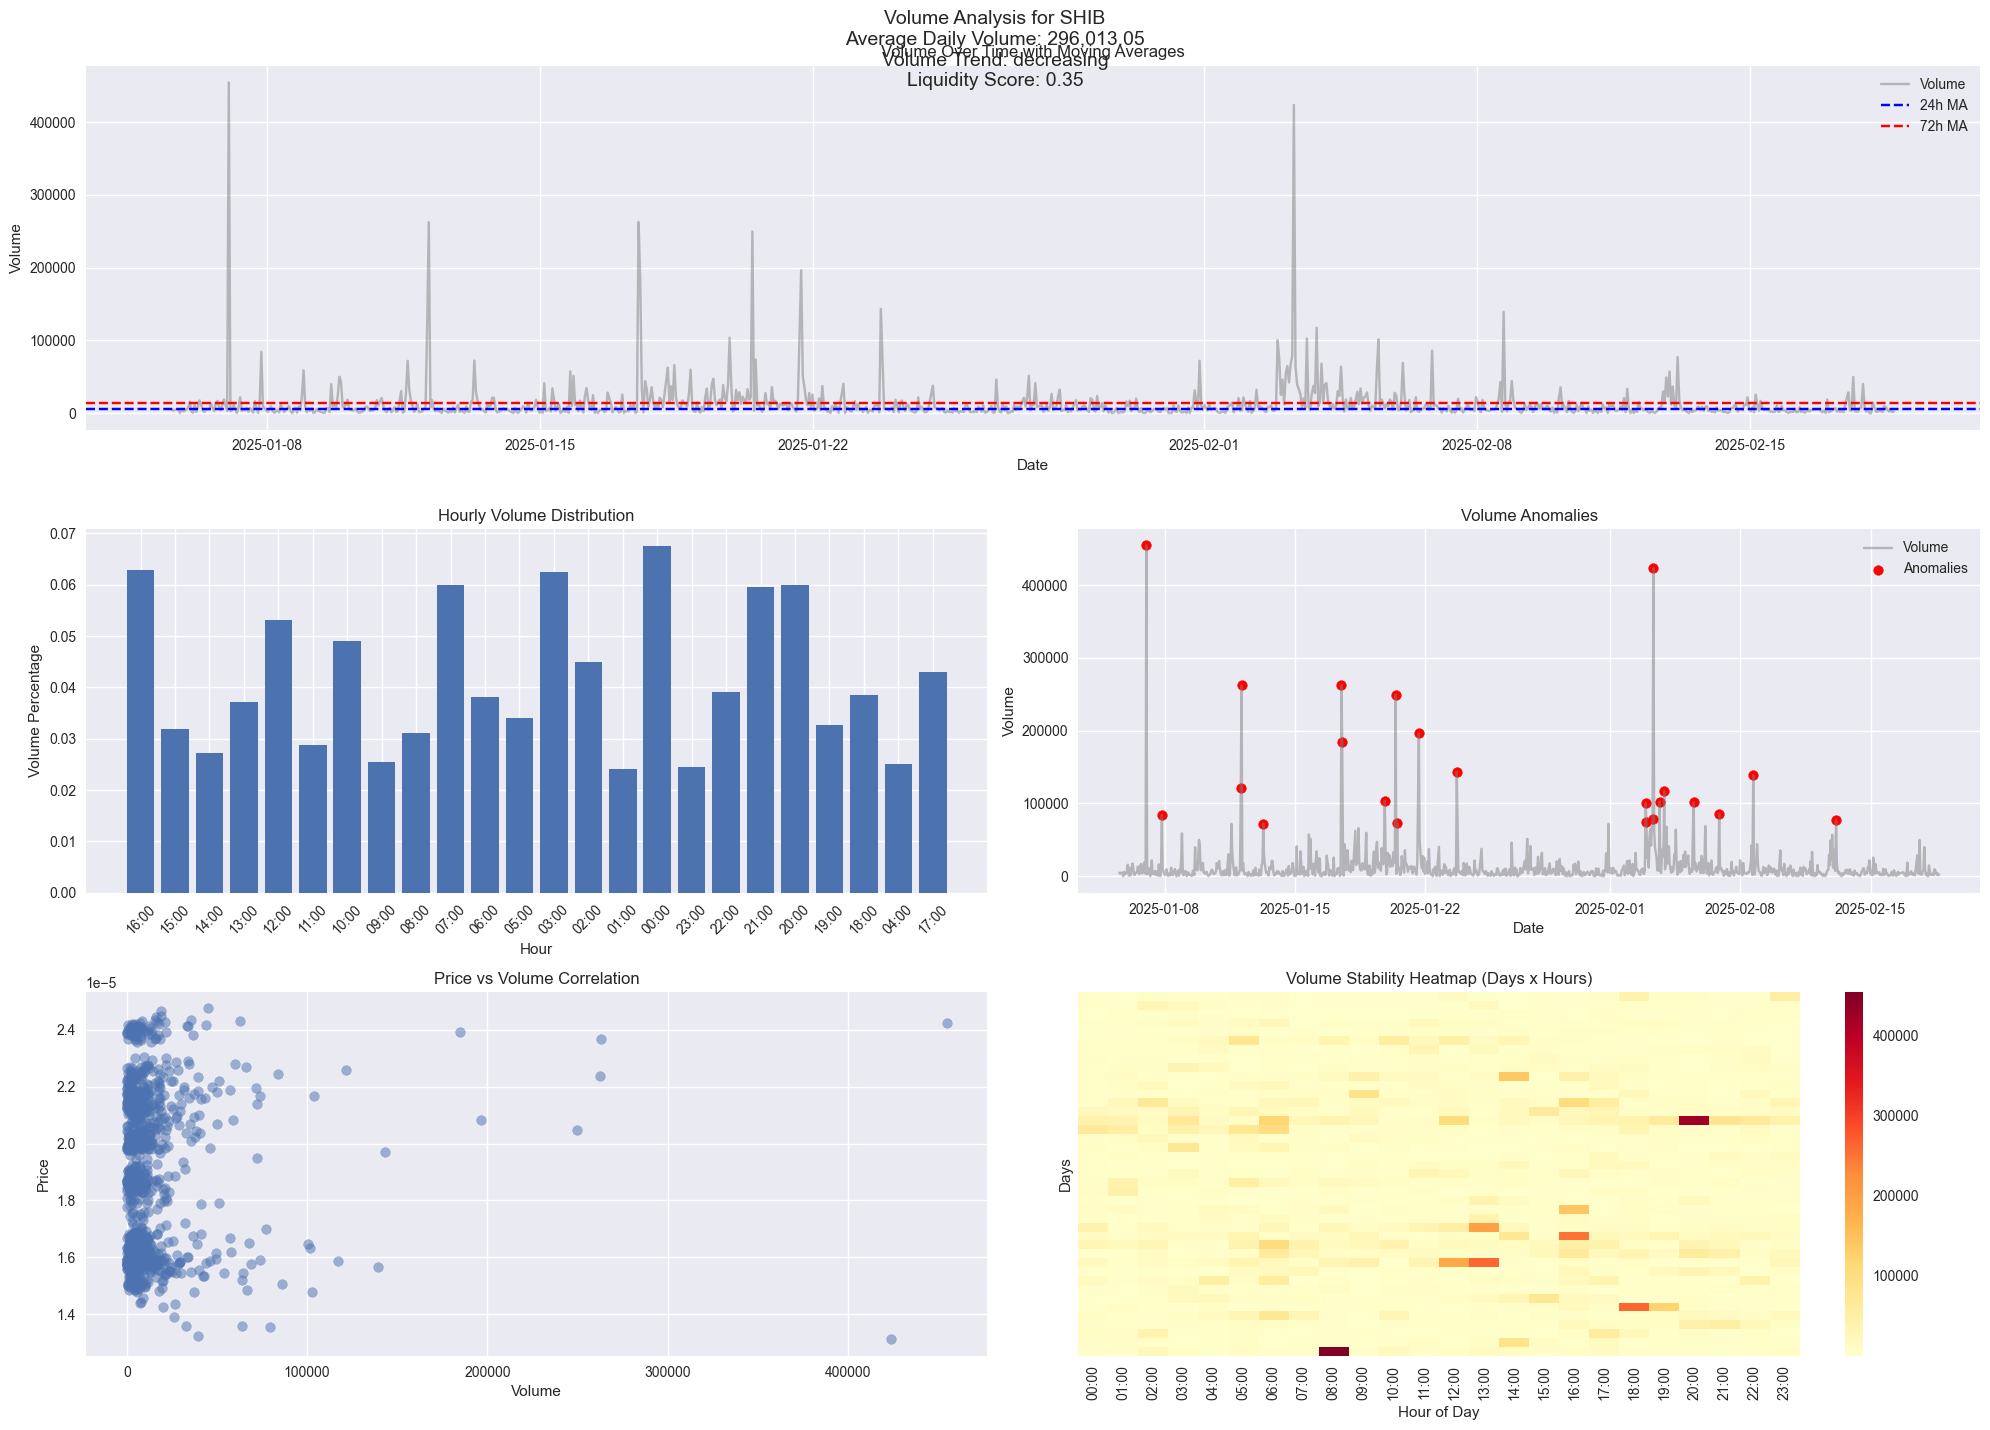

In [52]:
# Get data and analysis
ohlcv_data = get_ohlcv_data(SHIB_INU)
analysis = analyze_token_volume_comprehensive(SHIB_INU, ohlcv_data)

# Create visualizations
visualize_volume_analysis(ohlcv_data, analysis)

## Price Pattern Analysis

In [10]:
data = get_ohlcv_data(SHIB_INU)

In [14]:
def analyze_price_patterns(ohlcv_data: list) -> dict:
    """
    Analyze price patterns and technical indicators from OHLCV data
    
    Args:
        ohlcv_data (list): List of hourly OHLCV data points where each point is
                          [timestamp, open, high, low, close, volume]
    
    Returns:
        dict: Price analysis with the following metrics:
            - price_trends: Overall trend direction and strength
            - volatility_metrics: Various volatility measures
            - support_resistance: Key price levels
            - candlestick_patterns: Identified patterns
            - technical_indicators: Common indicators like RSI, MACD
    """
    # Extract price data
    timestamps = [point[0] for point in ohlcv_data]
    opens = [point[1] for point in ohlcv_data]
    highs = [point[2] for point in ohlcv_data]
    lows = [point[3] for point in ohlcv_data]
    closes = [point[4] for point in ohlcv_data]
    
    # Calculate basic price metrics
    current_price = closes[-1]
    price_change = ((closes[-1] - closes[0]) / closes[0]) * 100
    
    # Calculate volatility
    daily_returns = [(closes[i] - closes[i-1])/closes[i-1] 
                    for i in range(1, len(closes))]
    volatility = (sum(r**2 for r in daily_returns) / len(daily_returns))**0.5 * 100
    
    # Calculate Average True Range (ATR)
    true_ranges = []
    for i in range(1, len(ohlcv_data)):
        high = highs[i]
        low = lows[i]
        prev_close = closes[i-1]
        true_ranges.append(max([
            high - low,  # Current high-low
            abs(high - prev_close),  # Current high - prev close
            abs(low - prev_close)   # Current low - prev close
        ]))
    atr = sum(true_ranges) / len(true_ranges) if true_ranges else 0
    
    # Identify support and resistance levels using price clusters
    price_points = sorted(lows + highs)
    clusters = []
    current_cluster = [price_points[0]]
    
    for price in price_points[1:]:
        if price - current_cluster[-1] <= atr:  # Use ATR as threshold
            current_cluster.append(price)
        else:
            if len(current_cluster) > len(price_points) * 0.05:  # Min 5% of points
                clusters.append(sum(current_cluster) / len(current_cluster))
            current_cluster = [price]
    
    # Calculate RSI
    def calculate_rsi(prices: list, periods: int = 14) -> float:
        if len(prices) < periods:
            return 50  # Default value if not enough data
            
        deltas = [prices[i] - prices[i-1] for i in range(1, len(prices))]
        gains = [d if d > 0 else 0 for d in deltas]
        losses = [-d if d < 0 else 0 for d in deltas]
        
        avg_gain = sum(gains[-periods:]) / periods
        avg_loss = sum(losses[-periods:]) / periods
        
        if avg_loss == 0:
            return 100
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    rsi = calculate_rsi(closes)
    
    # Identify candlestick patterns
    patterns = []
    for i in range(len(ohlcv_data)-1):
        # Doji
        if abs(opens[i] - closes[i]) <= abs(highs[i] - lows[i]) * 0.1:
            patterns.append({
                'pattern': 'Doji',
                'timestamp': datetime.fromtimestamp(timestamps[i]).strftime('%Y-%m-%d %H:%M:%S')
            })
        
        # Hammer
        body = abs(opens[i] - closes[i])
        lower_wick = min(opens[i], closes[i]) - lows[i]
        upper_wick = highs[i] - max(opens[i], closes[i])
        if lower_wick > body * 2 and upper_wick < body * 0.5:
            patterns.append({
                'pattern': 'Hammer',
                'timestamp': datetime.fromtimestamp(timestamps[i]).strftime('%Y-%m-%d %H:%M:%S')
            })
    
    return {
        'price_trends': {
            'current_price': current_price,
            'price_change_percentage': price_change,
            'trend_direction': 'Uptrend' if price_change > 5 else 
                             'Downtrend' if price_change < -5 else 'Sideways',
            'trend_strength': abs(price_change) / volatility if volatility > 0 else 0
        },
        'volatility_metrics': {
            'volatility_percentage': volatility,
            'atr': atr,
            'price_range': {
                'high': max(highs),
                'low': min(lows),
                'range_percentage': (max(highs) - min(lows)) / min(lows) * 100
            }
        },
        'support_resistance': {
            'support_levels': sorted([level for level in clusters if level < current_price])[-3:],
            'resistance_levels': sorted([level for level in clusters if level > current_price])[:3]
        },
        'technical_indicators': {
            'rsi': rsi,
            'rsi_signal': 'Oversold' if rsi < 30 else 'Overbought' if rsi > 70 else 'Neutral',
            'price_vs_sma': {
                'above_20_sma': current_price > sum(closes[-20:]) / 20 if len(closes) >= 20 else None,
                'above_50_sma': current_price > sum(closes[-50:]) / 50 if len(closes) >= 50 else None
            }
        },
        'candlestick_patterns': patterns,
        'analysis_period': {
            'start': datetime.fromtimestamp(timestamps[-1]).strftime('%Y-%m-%d %H:%M:%S'),
            'end': datetime.fromtimestamp(timestamps[0]).strftime('%Y-%m-%d %H:%M:%S')
        }
    }


def calculate_fibonacci_levels(ohlcv_data: list) -> dict:
    """
    Calculate Fibonacci retracement and extension levels
    
    Args:
        ohlcv_data (list): OHLCV data points
        
    Returns:
        dict: Fibonacci levels and their prices
    """
    highs = [point[2] for point in ohlcv_data]
    lows = [point[3] for point in ohlcv_data]
    
    swing_high = max(highs)
    swing_low = min(lows)
    price_range = swing_high - swing_low
    
    # Common Fibonacci ratios
    fib_ratios = {
        'Extension 1.618': 1.618,
        'Extension 1.272': 1.272,
        'Extension 1.000': 1.000,
        'Retracement 0.786': 0.786,
        'Retracement 0.618': 0.618,
        'Retracement 0.500': 0.500,
        'Retracement 0.382': 0.382,
        'Retracement 0.236': 0.236
    }
    
    fib_levels = {}
    for name, ratio in fib_ratios.items():
        if 'Extension' in name:
            fib_levels[name] = swing_high + (price_range * (ratio - 1))
        else:
            fib_levels[name] = swing_high - (price_range * ratio)
            
    return fib_levels

def calculate_macd(prices: list, fast_period: int = 12, 
                  slow_period: int = 26, signal_period: int = 9) -> dict:
    """
    Calculate MACD (Moving Average Convergence Divergence)
    
    Args:
        prices (list): List of closing prices
        fast_period (int): Fast EMA period
        slow_period (int): Slow EMA period
        signal_period (int): Signal line period
        
    Returns:
        dict: MACD line, signal line, and histogram values
    """
    def ema(data: list, period: int) -> list:
        multiplier = 2 / (period + 1)
        ema_values = [data[0]]
        for price in data[1:]:
            ema_values.append((price * multiplier) + 
                            (ema_values[-1] * (1 - multiplier)))
        return ema_values
    
    # Calculate MACD line
    fast_ema = ema(prices, fast_period)
    slow_ema = ema(prices, slow_period)
    macd_line = [fast - slow for fast, slow in zip(fast_ema[-len(slow_ema):], slow_ema)]
    
    # Calculate signal line
    signal_line = ema(macd_line, signal_period)
    
    # Calculate histogram
    histogram = [macd - signal for macd, signal in zip(macd_line[-len(signal_line):], 
                                                      signal_line)]
    
    return {
        'macd_line': macd_line[-len(histogram):],
        'signal_line': signal_line,
        'histogram': histogram
    }

def calculate_bollinger_bands(prices: list, period: int = 20, 
                            std_dev: float = 2.0) -> dict:
    """
    Calculate Bollinger Bands
    
    Args:
        prices (list): List of closing prices
        period (int): Moving average period
        std_dev (float): Number of standard deviations
        
    Returns:
        dict: Upper band, middle band (SMA), and lower band values
    """
    if len(prices) < period:
        return None
        
    bands = []
    for i in range(period-1, len(prices)):
        window = prices[i-period+1:i+1]
        sma = sum(window) / period
        std = (sum((x - sma) ** 2 for x in window) / period) ** 0.5
        
        bands.append({
            'middle_band': sma,
            'upper_band': sma + (std_dev * std),
            'lower_band': sma - (std_dev * std)
        })
    
    return bands

def calculate_vwap(ohlcv_data: list) -> list:
    """
    Calculate Volume Weighted Average Price (VWAP)
    
    Args:
        ohlcv_data (list): OHLCV data points
        
    Returns:
        list: VWAP values
    """
    cumulative_pv = 0
    cumulative_volume = 0
    vwap_values = []
    
    for point in ohlcv_data:
        typical_price = (point[2] + point[3] + point[4]) / 3  # (high + low + close) / 3
        volume = point[5]
        
        cumulative_pv += typical_price * volume
        cumulative_volume += volume
        
        vwap = cumulative_pv / cumulative_volume if cumulative_volume > 0 else typical_price
        vwap_values.append(vwap)
    
    return vwap_values

def calculate_momentum_indicators(ohlcv_data: list) -> dict:
    """
    Calculate various momentum indicators
    
    Args:
        ohlcv_data (list): OHLCV data points
        
    Returns:
        dict: Various momentum indicators
    """
    closes = [point[4] for point in ohlcv_data]
    
    # Rate of Change (ROC)
    period = 14
    roc = []
    for i in range(period, len(closes)):
        roc_val = ((closes[i] - closes[i-period]) / closes[i-period]) * 100
        roc.append(roc_val)
    
    # Stochastic Oscillator
    def calculate_stochastic(high: float, low: float, close: float, 
                           period: int = 14) -> tuple:
        lowest_low = min(low)
        highest_high = max(high)
        k = 100 * (close - lowest_low) / (highest_high - lowest_low) if highest_high != lowest_low else 0
        return k
    
    highs = [point[2] for point in ohlcv_data]
    lows = [point[3] for point in ohlcv_data]
    
    stoch_k = []
    for i in range(period, len(closes)):
        k = calculate_stochastic(highs[i-period:i], lows[i-period:i], closes[i])
        stoch_k.append(k)
    
    # Simple moving average of Stochastic K to get D
    stoch_d = []
    d_period = 3
    for i in range(d_period-1, len(stoch_k)):
        d = sum(stoch_k[i-d_period+1:i+1]) / d_period
        stoch_d.append(d)
    
    return {
        'roc': roc,
        'stochastic': {
            'k_line': stoch_k,
            'd_line': stoch_d
        },
        'momentum': [closes[i] - closes[i-period] for i in range(period, len(closes))],
        'interpretation': {
            'roc_signal': 'Bullish' if roc[-1] > 0 else 'Bearish',
            'stochastic_signal': 'Overbought' if stoch_k[-1] > 80 else 
                                'Oversold' if stoch_k[-1] < 20 else 'Neutral'
        }
    }

In [15]:
def analyze_technical_indicators(ohlcv_data: list) -> dict:
    """
    Perform comprehensive technical analysis using all indicators
    
    Args:
        ohlcv_data (list): OHLCV data points
        
    Returns:
        dict: Complete technical analysis with all indicators
    """
    closes = [point[4] for point in ohlcv_data]
    
    # Calculate all indicators
    fib_levels = calculate_fibonacci_levels(ohlcv_data)
    macd_data = calculate_macd(closes)
    bollinger = calculate_bollinger_bands(closes)
    vwap = calculate_vwap(ohlcv_data)
    momentum = calculate_momentum_indicators(ohlcv_data)
    
    # Combine signals for trading decisions
    current_price = closes[-1]
    bb_latest = bollinger[-1] if bollinger else None
    
    signals = []
    
    # MACD signals
    if macd_data['histogram'][-1] > 0 and macd_data['histogram'][-2] <= 0:
        signals.append('MACD bullish crossover')
    elif macd_data['histogram'][-1] < 0 and macd_data['histogram'][-2] >= 0:
        signals.append('MACD bearish crossover')
    
    # Bollinger Bands signals
    if bb_latest:
        if current_price > bb_latest['upper_band']:
            signals.append('Price above upper Bollinger Band - potential overbought')
        elif current_price < bb_latest['lower_band']:
            signals.append('Price below lower Bollinger Band - potential oversold')
    
    # VWAP signals
    if current_price > vwap[-1]:
        signals.append('Price above VWAP - bullish')
    else:
        signals.append('Price below VWAP - bearish')
    
    return {
        'fibonacci_levels': fib_levels,
        'macd': {
            'values': macd_data,
            'trend': 'Bullish' if macd_data['histogram'][-1] > 0 else 'Bearish'
        },
        'bollinger_bands': {
            'current': bb_latest,
            'volatility': (bb_latest['upper_band'] - bb_latest['lower_band']) / 
                         bb_latest['middle_band'] if bb_latest else None
        },
        'vwap': {
            'current': vwap[-1],
            'trend': 'Above VWAP' if current_price > vwap[-1] else 'Below VWAP'
        },
        'momentum_indicators': momentum,
        'trading_signals': {
            'signals': signals,
            'strength': len([s for s in signals if 'bullish' in s.lower()]) - 
                       len([s for s in signals if 'bearish' in s.lower()]),
            'overall_bias': 'Bullish' if len([s for s in signals if 'bullish' in s.lower()]) >
                           len([s for s in signals if 'bearish' in s.lower()]) else 'Bearish'
        }
    }

In [24]:
def visualize_technical_analysis(ohlcv_data: list, analysis_results: dict) -> None:
    """
    Create visualizations for technical analysis results using standard libraries
    
    Args:
        ohlcv_data (list): OHLCV data points
        analysis_results (dict): Output from analyze_technical_indicators
    """
    try:
        # Check for required packages
        import matplotlib.pyplot as plt
        import pandas as pd
        import numpy as np
        from matplotlib.gridspec import GridSpec
        
    except ImportError:
        print("Please install required packages: matplotlib, pandas, numpy")
        print("Run: pip install matplotlib pandas numpy")
        return
        
    try:
        # Convert data to pandas DataFrame
        timestamps = [datetime.fromtimestamp(point[0]) for point in ohlcv_data]
        df = pd.DataFrame({
            'Open': [point[1] for point in ohlcv_data],
            'High': [point[2] for point in ohlcv_data],
            'Low': [point[3] for point in ohlcv_data],
            'Close': [point[4] for point in ohlcv_data],
            'Volume': [point[5] for point in ohlcv_data]
        }, index=timestamps)
        
        # Set style
        plt.style.use('seaborn')
        
        # Create figure with subplots
        fig = plt.figure(figsize=(20, 15))
        gs = GridSpec(3, 2, figure=fig)
        
        # 1. Price and Volume Chart
        ax1 = fig.add_subplot(gs[0, :])
        # Plot price
        ax1.plot(df.index, df['Close'], label='Price', color='blue', linewidth=1)
        
        # Add Bollinger Bands if available
        if 'bollinger_bands' in analysis_results:
            bb_data = analysis_results['bollinger_bands']
            if isinstance(bb_data, list) and bb_data:  # Check if it's a non-empty list
                upper_band = [b['upper_band'] for b in bb_data]
                middle_band = [b['middle_band'] for b in bb_data]
                lower_band = [b['lower_band'] for b in bb_data]
                
                ax1.plot(df.index[-len(upper_band):], upper_band,
                        'r--', label='Upper BB', alpha=0.7)
                ax1.plot(df.index[-len(middle_band):], middle_band,
                        'g--', label='Middle BB', alpha=0.7)
                ax1.plot(df.index[-len(lower_band):], lower_band,
                        'b--', label='Lower BB', alpha=0.7)
        
        # Add VWAP if available
        if 'vwap' in analysis_results:
            vwap_values = analysis_results['vwap']
            if isinstance(vwap_values, list):
                ax1.plot(df.index[-len(vwap_values):], vwap_values,
                        'purple', label='VWAP', alpha=0.7)
        
        # Add volume bars on secondary axis
        ax1v = ax1.twinx()
        ax1v.bar(df.index, df['Volume'], alpha=0.3, color='gray', label='Volume')
        ax1v.set_ylabel('Volume')
        
        ax1.set_title('Price Action with Technical Indicators')
        ax1.legend(loc='upper left')
        ax1v.legend(loc='upper right')
        
        # 2. MACD
        if 'macd' in analysis_results and 'values' in analysis_results['macd']:
            ax2 = fig.add_subplot(gs[1, 0])
            macd_data = analysis_results['macd']['values']
            
            macd_line = macd_data['macd_line']
            signal_line = macd_data['signal_line']
            histogram = macd_data['histogram']
            
            # Plot MACD components
            ax2.plot(df.index[-len(macd_line):], macd_line,
                    label='MACD', color='blue')
            ax2.plot(df.index[-len(signal_line):], signal_line,
                    label='Signal', color='orange')
            ax2.bar(df.index[-len(histogram):], histogram,
                   label='Histogram', color='gray', alpha=0.5)
            
            ax2.set_title('MACD')
            ax2.legend()
        
        # 3. Stochastic Oscillator
        if 'momentum_indicators' in analysis_results:
            ax3 = fig.add_subplot(gs[1, 1])
            momentum_data = analysis_results['momentum_indicators']
            
            if 'stochastic' in momentum_data:
                k_line = momentum_data['stochastic']['k_line']
                d_line = momentum_data['stochastic']['d_line']
                
                ax3.plot(df.index[-len(k_line):], k_line,
                        label='Stochastic %K', color='blue')
                ax3.plot(df.index[-len(d_line):], d_line,
                        label='Stochastic %D', color='orange')
                
                # Add overbought/oversold lines
                ax3.axhline(y=80, color='r', linestyle='--', alpha=0.5)
                ax3.axhline(y=20, color='g', linestyle='--', alpha=0.5)
                
                ax3.set_title('Stochastic Oscillator')
                ax3.legend()
        
        # 4. Fibonacci Levels
        if 'fibonacci_levels' in analysis_results:
            ax4 = fig.add_subplot(gs[2, 0])
            ax4.plot(df.index, df['Close'], color='black', alpha=0.7)
            
            fib_levels = analysis_results['fibonacci_levels']
            colors = plt.cm.rainbow(np.linspace(0, 1, len(fib_levels)))
            
            for (level_name, price), color in zip(fib_levels.items(), colors):
                ax4.axhline(y=price, color=color, linestyle='--',
                           alpha=0.5, label=f"{level_name}: {price:.6f}")
            
            ax4.set_title('Fibonacci Levels')
            ax4.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        
        # 5. Volume Profile
        ax5 = fig.add_subplot(gs[2, 1])
        price_bins = np.linspace(df['Low'].min(), df['High'].max(), 50)
        volume_profile = []
        
        for i in range(len(price_bins)-1):
            mask = (df['Low'] >= price_bins[i]) & (df['High'] < price_bins[i+1])
            volume_profile.append(df.loc[mask, 'Volume'].sum())
            
        ax5.barh(price_bins[:-1], volume_profile,
                height=price_bins[1]-price_bins[0], alpha=0.3)
        ax5.set_title('Volume Profile')
        
        # Add overall title with key signals
        if 'trading_signals' in analysis_results:
            signals = analysis_results['trading_signals'].get('signals', [])
            bias = analysis_results['trading_signals'].get('overall_bias', 'Unknown')
            
            plt.suptitle(
                f"Technical Analysis Overview\n" +
                f"Overall Bias: {bias}\n" +
                f"Latest Signals: {', '.join(signals[-2:] if signals else ['No signals'])}",
                fontsize=14, y=0.95
            )
        
        plt.tight_layout()
        plt.show()
        
    except Exception as e:
        print(f"Error creating visualizations: {str(e)}")
        import traceback
        traceback.print_exc()
        return

/var/folders/74/v24b4m595rbg5hcpp2pm8gb00000gn/T/ipykernel_2580/2548562044.py:33: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


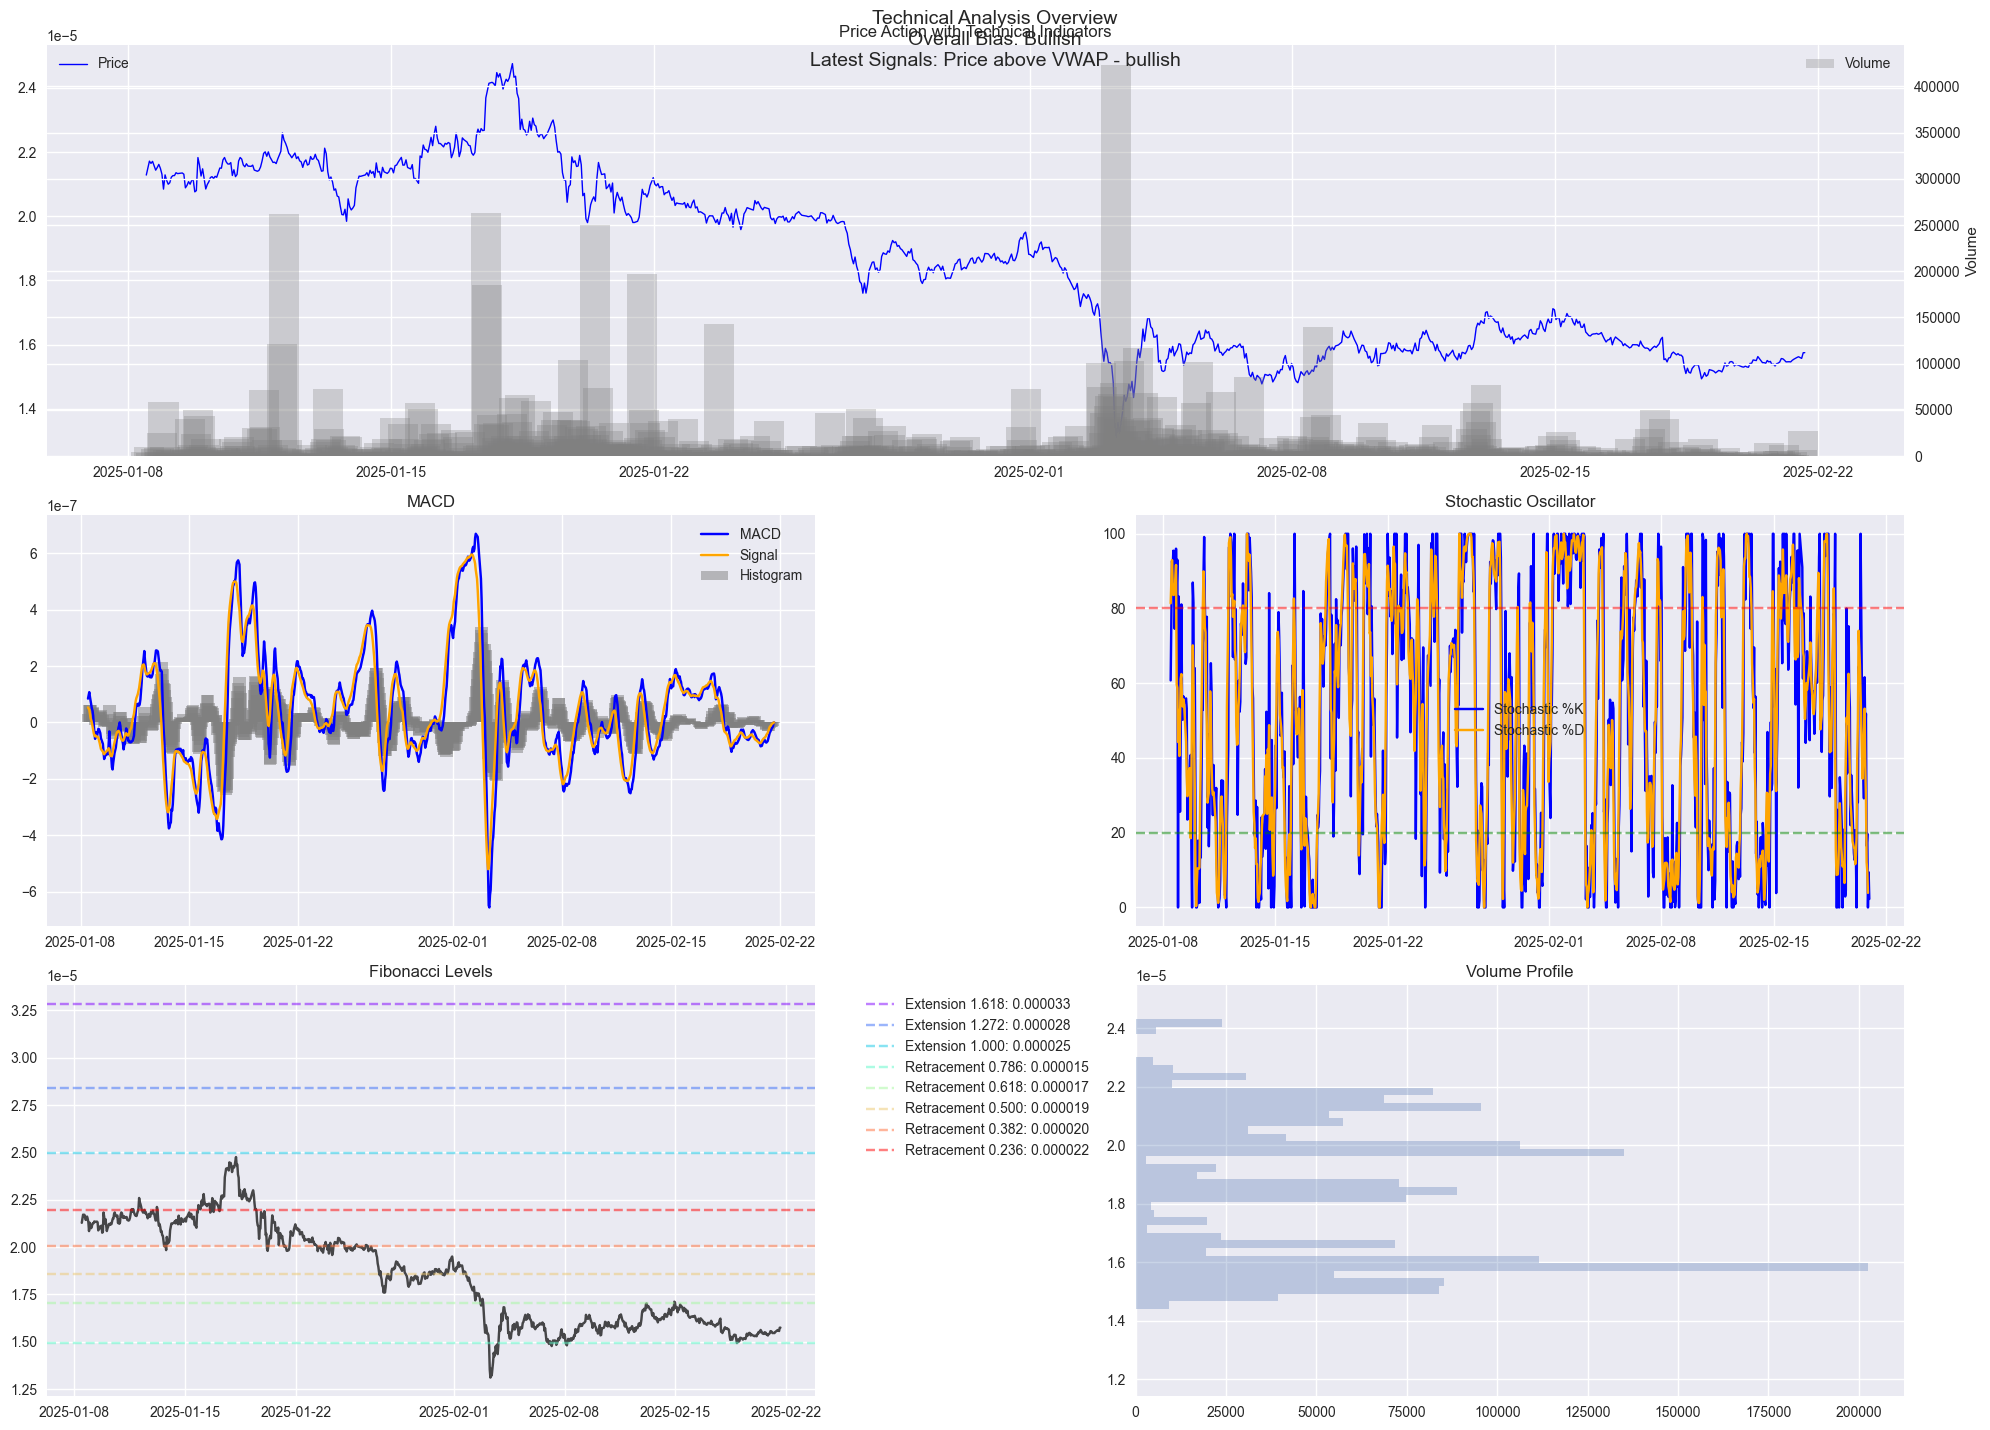

In [25]:
# Example usage
# analysis = analyze_technical_indicators(data)
visualize_technical_analysis(data, analysis)

## Smart Contract Interaction